In [279]:
%load_ext autoreload
%autoreload 2
    
from d3pm_sc.ct_sched_cond import ScheduleCondition
from d3pm_sc.masking_diffusion import MaskingDiffusion
from d3pm_sc.d3pm_classic import D3PMClassic
from d3pm_sc.unet import UNet, SimpleUNet
from d3pm_sc.dit import DiT_Llama
from d3pm_sc import utils
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger


import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10
from torchvision.utils import make_grid
from tqdm import tqdm

from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [521]:
N = 256  # number of classes for discretized state per pixel
n_channel = 3
gamma = 0
hybrid_loss_coeff = 0.01
logistic_pars = False
fix_x_t_bias = False
lr = 2e-4
grad_clip_val = 1

s_dim = 4
conditional = True
forward_kwargs = {"type":"gaussian",
                  "normalized": False,
                  "bandwidth":1 / 7}

batch_size = 16
n_epoch = 14

nn_params = {"n_channel": n_channel, 
             "N": N,
             "n_T": 500,
             "schedule_conditioning": True,
             "s_dim":4,
            }
x0_model_class = UNet

# x0_model_class = DiT_Llama
# nn_params['dim'] = 1024

##### Pick model
# # Schedule conditioning
# model = ScheduleCondition(x0_model_class, nn_params, num_classes=N, hybrid_loss_coeff=hybrid_loss_coeff, gamma=gamma,
#                           forward_kwargs=forward_kwargs, logistic_pars=logistic_pars, fix_x_t_bias=fix_x_t_bias, lr=lr, grad_clip_val=grad_clip_val)

# # Masking
nn_params["N"] += 1
nn_params["schedule_conditioning"] = False
model = MaskingDiffusion(x0_model_class, nn_params, num_classes=N, hybrid_loss_coeff=0.01).cuda()


##### Load data
dataset = CIFAR10(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
)
def collate_fn(batch):
    x, cond = zip(*batch)
    x = torch.stack(x)
    cond = torch.tensor(cond)
    cond = (cond * conditional)
    x = (x * (N - 1)).round().long().clamp(0, N - 1)
    return x, cond
train_size = int(len(dataset) * 0.9)
dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=16, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, collate_fn=collate_fn)


Files already downloaded and verified


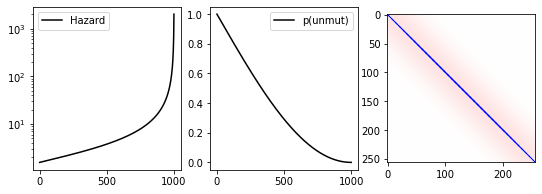

In [522]:
steps = torch.arange(1000 + 1, dtype=torch.float64) / 1000

fig, ax = plt.subplots(1, 3, figsize=[9, 3])
ax[0].semilogy(model.beta(steps), label="Hazard", color='black')
ax[0].legend()

alpha_bar = torch.exp(model.log_alpha(steps))
ax[1].plot(alpha_bar, label="p(unmut)", color='black')
ax[1].legend()

L = utils.get_inf_gens(forward_kwargs, N)
ax[2].imshow(L, vmin=-0.1, vmax=0.1, cmap='bwr')

In [534]:
ps = np.array([np.product(p.shape) for p in model.x0_model.parameters()])
ps.sum()

/tmp/ipykernel_1578627/1646885609.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  ps = np.array([np.product(p.shape) for p in model.x0_model.parameters()])


36631811

In [532]:
model.x0_model.N

257

In [530]:
ps = [p.shape for p in model.x0_model.conv_out.parameters()]

ps

[torch.Size([771, 128, 3, 3]), torch.Size([771])]

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(project="debugging")
lightning_model = model

trainer = Trainer(max_epochs=n_epoch, accelerator='auto', devices='auto', logger=wandb_logger)
trainer.fit(lightning_model, dataloader, test_dataloader)

In [91]:
import wandb
wandb.finish()

epoch,▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▅▅▅▅▁▁▁▁▁▃▃▃▃▅▅▅▅▅▆▆▆▆▆█
param_norm,▃▄▃▇▇██▁▂▂▂▂▃▃▃▄▄▄▄▄▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆
train_ce_loss,▁▁▇████▆▇▆▆▆▅▅▅▆▅▆▅▅▆▅▅▅▅▄▄▅▅▄▅▅▄▄▅▄▄▄▅▄
train_loss,▂▁▇█▇▆▇▇▅▆▅▅▅▆▅▄▅▄▆▄▆▆▆▆▅▆▆▄▄▅▄▅▄▄▄▅▄▅▄▄
trainer/global_step,▁▁▁▂▂▂▃▁▁▂▂▃▃▃▄▄▄▅▅▅▁▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇██
val_ce_loss,█▄▃▂▂▁▁
val_l01,█▄▃▃▂▁▁
val_l1,▁▁▁████
epoch,4
param_norm,2228.13696
train_ce_loss,2.51787


In [284]:
len(ps)

94

In [270]:
ps

array([147456,    128, 147456,    128,    128,    128,    128,    128,
        65536,    128, 147456,    128, 147456,    128,    128,    128,
          128,    128,  65536,    128, 147456,    128])

In [142]:
c = [list(p.shape) for p in model.x0_model.up_blocks.parameters()]

AttributeError: 'UNet' object has no attribute 'up_blocks'

In [131]:
len(c)

168

In [133]:
[l for l in c if len(l)>3]

[[256, 512, 3, 3],
 [256, 256, 3, 3],
 [256, 512, 1, 1],
 [256, 512, 3, 3],
 [256, 256, 3, 3],
 [256, 512, 1, 1],
 [256, 512, 3, 3],
 [256, 256, 3, 3],
 [256, 512, 1, 1],
 [256, 512, 3, 3],
 [256, 256, 3, 3],
 [256, 512, 1, 1],
 [256, 512, 3, 3],
 [256, 256, 3, 3],
 [256, 512, 1, 1],
 [256, 512, 3, 3],
 [256, 256, 3, 3],
 [256, 512, 1, 1],
 [256, 512, 3, 3],
 [256, 256, 3, 3],
 [256, 512, 1, 1],
 [256, 512, 3, 3],
 [256, 256, 3, 3],
 [256, 512, 1, 1],
 [128, 384, 3, 3],
 [128, 128, 3, 3],
 [128, 384, 1, 1],
 [128, 256, 3, 3],
 [128, 128, 3, 3],
 [128, 256, 1, 1],
 [128, 256, 3, 3],
 [128, 128, 3, 3],
 [128, 256, 1, 1],
 [128, 256, 3, 3],
 [128, 128, 3, 3],
 [128, 256, 1, 1]]